In [999]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = -1 #number of cores for parallelization

# System parameters for spin chain
J = 1.0         # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 0.8   # J(1+gamma)XX + J(1-gamma)YY (ignoring other factors, see paper or notes for defn.)
sites = 3     # system size, for ground state pick even N as odd N is not verified (pi or -pi mode becomes special)
h1_amp = 0.0    # amplitude of the drive for periodic transverse field
h1_period = 5.0 # period of the drive for periodic transverse field
h0 = 1.5      # static transverse field
stroboscopic_times = 10

method = 'RK45'  # integration method #'RK45' (4th order), 'DOP853' (8th order), 'BDF'
rtol = 10**(-12) # relative tolerance of integration scheme
atol = 10**(-14) # absolute tolerance of integration scheme
dt = 0.01        # return results with this step (does not affect integration accuracy)

# Initial state
initial_state = 'spin_up' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'PBC' # USE PBC ONLY FOR NOW (which restricts valid parity for comparison with TFIM)
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.


Initial Conditions and define Nambu Hamiltonian

In [1000]:

# Build correlation matrices for initial condition
obs, Dag_obs = methods.initialize_state(sites, gamma, J, h0, 0, boundary_conditions, initial_state)

# Initial Nambu correlation matrix
Corr_mat = copy.copy(obs)
Dag_mat = copy.copy(Dag_obs)

Nambu_Correlator = np.zeros([2*sites,2*sites],dtype = complex) # note the way the matrix is defined. <c_i† c_j> is lower right block (not top left!)
Nambu_Correlator[0:sites, 0:sites]   = np.eye(sites) - Corr_mat.T      # <c_i c_j†>
Nambu_Correlator[0:sites, sites:]    = -Dag_mat.T                      # <c_i c_j>
Nambu_Correlator[sites:, 0:sites]    = -Dag_mat.conj()                 # <c_i† c_j†>
Nambu_Correlator[sites:, sites:]     = Corr_mat                        # <c_i† c_j>

# Definition of nambu Hamiltonian
def Hnambu(J, gamma, h, sites):
    size = 2 * sites
    Hnambu = np.zeros((size, size), dtype=complex)

    for jj in range(size):
        for kk in range(size):
            if jj < sites and kk < sites:
                # Upper-left block: kinetic terms with PBC
                if jj == (kk + 1) % sites or jj == (kk - 1) % sites:
                    Hnambu[jj, kk] = -J / 2.0
                if jj == kk:
                    Hnambu[jj, kk] = -h #/ 4.0

            elif jj >= sites and kk >= sites:
                # Lower-right block: diagonal with h
                if jj == kk:
                    Hnambu[jj, kk] = h #/ 4.0

                if jj == (kk + 1) % sites + sites or jj == (kk - 1) % sites + sites:
                    Hnambu[jj, kk] = J / 2.0

            elif jj < sites and kk >= sites:


            #     # Upper-right block: pairing terms

                if kk == (jj+1) % sites + sites:

                    Hnambu[jj, kk] = J * gamma / 2.0 
                    Hnambu[kk - sites, jj + sites] = -J * gamma / 2.0 

            elif jj >= sites and kk < sites:
                # Lower-left block: pairing terms (Hermitian conjugate)
                if jj == (kk + 1) % sites + sites:

                    Hnambu[jj, kk] = J * gamma / 2.0
                    Hnambu[kk + sites, jj - sites] = -J * gamma / 2.0

    return Hnambu
 


Perform integration over a period and construct floquet unitary

In [1001]:
oneperiod_steps = int(h1_period/dt) # number of steps in one period, make sure this is integer.
times = oneperiod_steps

def system_rhs(t, y_flat, J, gamma, h0, h1, omega, sites):

    h_t = h0 + h1 * np.sin(omega * t)

    Ham_t = Hnambu(J,  gamma, h_t, sites)

    y = y_flat.reshape((2*sites, 2*sites))  # Reshape to match Ham

    # implement for extra accuracy
    yy = y.reshape((2*sites, 2*sites))
    Uu, _, Uv = np.linalg.svd(yy)
    y = Uu @ Uv  # Closest unitary matrix

    dydt = -1j * Ham_t @ y

    return dydt.flatten()
    
sol = solve_ivp(
    fun=lambda t, y: system_rhs(t, y, J, gamma, h0, h1_amp, 2 * np.pi / h1_period, sites),
    t_span=(0, dt * times),
    y0=np.identity(2 * sites,dtype=complex).flatten(),  # Flatten if system_rhs expects 1D array
    method=method,                        # e.g., 'RK45', 'DOP853', 'BDF'
    t_eval=dt * np.arange(times + 1),
    vectorized=False,
    atol=atol,
    rtol=rtol
)

Nambu_T_mat = []
for tt in range(0,times+1):

    UT =  sol.y[:,tt].reshape((2*sites, 2*sites)) #U_array[tt]  # Use the U_array instead of sol.y

    Nambu_T = np.dot(UT, np.dot(Nambu_Correlator, np.conjugate(np.transpose(UT))))

    Nambu_T_mat += [Nambu_T]

Nambu_T_mat = np.asarray(Nambu_T_mat)

# let us now compute the Floquet eigenvalues and eigenvectors (of the unitary matrix not the Floquet Hamiltonian)
w, v = lin.eig(UT)


Calculate the stroboscopic evolution uin Floquet eigenbasis

In [1002]:
# rotate into eigenbasis first, do time evolution, then rotate back

# Define and initialize
inv_v = np.linalg.inv(v)
Nambu_nT_fromdiag = []
Nambu_eigenbasis = np.dot(inv_v, Nambu_Correlator @ v)  # Rotate to eigenbasis

# Do stroboscopic evolution
for nn in range(0, stroboscopic_times+1):
    UTemp = np.diag(w**(nn))  
    Nambu_nT_diag = np.dot(UTemp, np.dot(Nambu_eigenbasis, np.conjugate(np.transpose(UTemp))))
    Nambu_nT_fromdiag +=  [np.dot(v, Nambu_nT_diag @ inv_v)] # rotate back and store the matrix in list
Nambu_nT_fromdiag = np.asarray(Nambu_nT_fromdiag) #convert list to array



In [1003]:
####### CHECK AGAINST DIRECT INTEGRATION OF CORRELATORS (element by element)
# Initialize Time parameters 
method = 'RK45' # integration method #'RK45' (4th order), 'DOP853' (8th order), 'BDF'
rtol = 10**(-12) # relative tolerance of integration scheme
atol = 10**(-14) # absolute tolerance of integration scheme
h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps+1)) # initialize periodic field, note + 1 time added here for RK4 and heun integration step endpoints
Corr_mat_list, Dag_mat_list, corr_diag = methods.integrator_matrices_eff(obs, Dag_obs, J, gamma, h0, h1, 10 * oneperiod_steps, dt, sites, boundary_conditions, method, atol, rtol)

0:00:01.550785 End Simulation


# Results

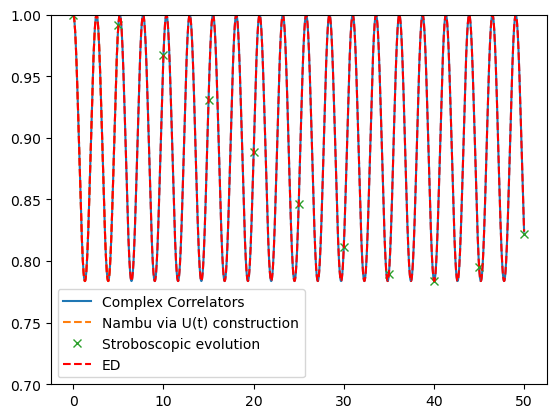

[[0.81537812-8.09358816e-18j 0.09231094+2.13398153e-16j
  0.09231094-5.15872901e-16j]
 [0.09231094-2.08874665e-16j 0.81537812+5.56323133e-17j
  0.09231094-1.31754000e-16j]
 [0.09231094+4.84201057e-16j 0.09231094+1.37932175e-16j
  0.81537812-4.35779997e-17j]]
Unitarity error at t=100.0: 2.61e-13


In [ ]:
Corr_mat_list = np.asarray(Corr_mat_list)

plt.plot(dt * np.arange(0,np.size(Corr_mat_list,0)),Corr_mat_list[:, 0, 0],"-",label = "Complex Correlators")

plt.plot(dt * np.arange(0,np.size(Nambu_T_mat,0)),Nambu_T_mat[:, sites, sites],"--",label = "Nambu via U(t) construction")

plt.plot(h1_period * np.arange(0,stroboscopic_times+1), Nambu_nT_fromdiag[:,sites,sites], "x", label = "Stroboscopic evolution") # check the value of the correlation matrix at the end of one period

ED_particle = 0.5 + np.load('/Users/samuelbegg/Desktop/Dump/magsites.npy')
plt.plot(0.01 * np.arange(0,np.size(ED_particle,1)),ED_particle[0,:],"--r",label = "ED")
plt.legend()
plt.ylim(0.7,1.0)
plt.show()


# check unitary error at time T (1 period), i.e. U^T U will deviate from Identity by a small amount
print(Corr_mat_list[-1] -  Nambu_T_mat[-1,0:sites,0:sites])
U = sol.y[:,-1].reshape((2*sites, 2*sites))
unitarity_error = np.linalg.norm(U.conj().T @ U - np.eye(2*sites))
print(f"Unitarity error at t={10000*dt}: {unitarity_error:.2e}")
